
# Image classifier for the SVHN dataset 

In [2]:
import tensorflow as tf
from scipy.io import loadmat

![SVHN overview image](data/svhn_examples.jpg)
Data: [SVHN dataset](http://ufldl.stanford.edu/housenumbers/). SVHN is obtained from house numbers in Google Street View images. 

Reference:
* Y. Netzer, T. Wang, A. Coates, A. Bissacco, B. Wu and A. Y. Ng. "Reading Digits in Natural Images with Unsupervised Feature Learning". NIPS Workshop on Deep Learning and Unsupervised Feature Learning, 2011.



In [3]:
# loading dataset
train = loadmat('data/train_32x32.mat')
test = loadmat('data/test_32x32.mat')

Both `train` and `test` are dictionaries with keys `X` and `y` for the input images and labels respectively.

## Preprocessing the dataset

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import random
import math

In [11]:
train_images = train['X'] 
train_labels = train['y']
test_images = test['X'] 
test_labels = test['y']

# scaling the numbers
train_images = train_images / 255.0
test_images = test_images / 255.0

# reshaping the inputs
train_images = np.moveaxis(train_images,-1,0)
test_images = np.moveaxis(test_images,-1,0)

# changing 0 number label from 10 to 0
train_labels[train_labels == 10] = 0
test_labels[test_labels == 10] = 0

In [12]:
train_images_grey = np.mean(train_images, axis=3)
train_images_grey = np.expand_dims(train_images_grey, axis=3) # add the channel dimension
test_images_grey = np.mean(test_images, axis=3)
test_images_grey = np.expand_dims(test_images_grey, axis=3) # add the channel dimension

In [13]:
def show_images(n,image_array,label_array, cmap=None):
    '''
    show random n number of images from image_array with corresponding label_array
    '''
    total_rows = math.floor(n/4)+1
    random_list = random.sample(range(0, image_array.shape[0]), n)
    fig, axes = plt.subplots(total_rows, 4, figsize=(16, total_rows*4))
    [axi.set_axis_off() for axi in axes.ravel()] # this line sets all axis off
    r = 0
    c = 0
    for i in random_list:
        image = image_array[i,:,:,:]
        #axes[r, c].set_axis_off()
        axes[r, c].imshow(np.squeeze(image), cmap=cmap)
        axes[r, c].set_title(f"Label: {label_array[i]} \n {i}th image in the dataset.")
        c += 1
        if c % 4 == 0:
            r += 1
            c = 0
    plt.show()

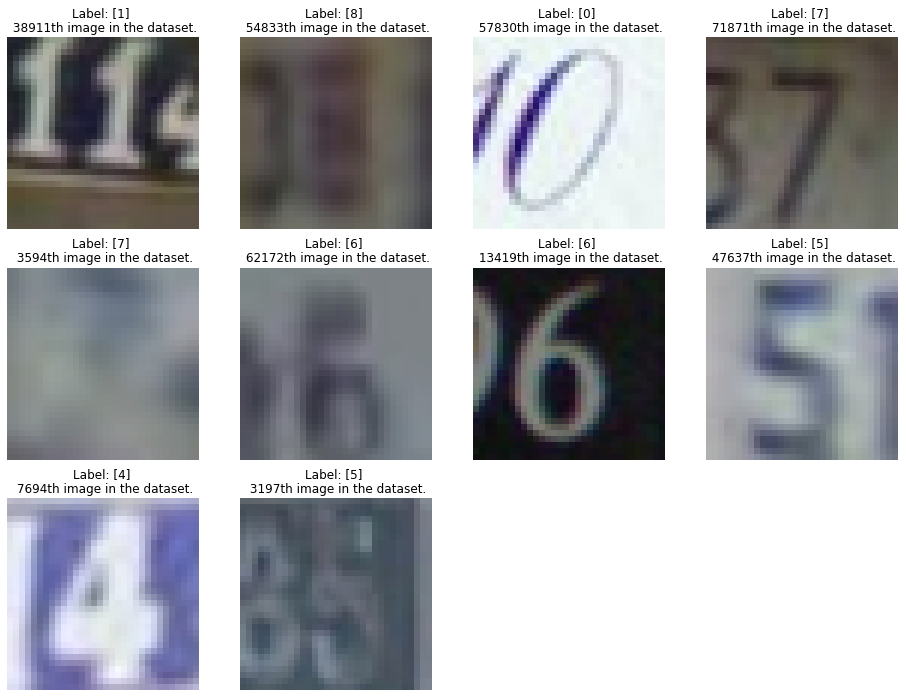

In [14]:
n = 10 # number of images to show
# showing images and correspoind labels from train set
show_images(n,train_images,train_labels)

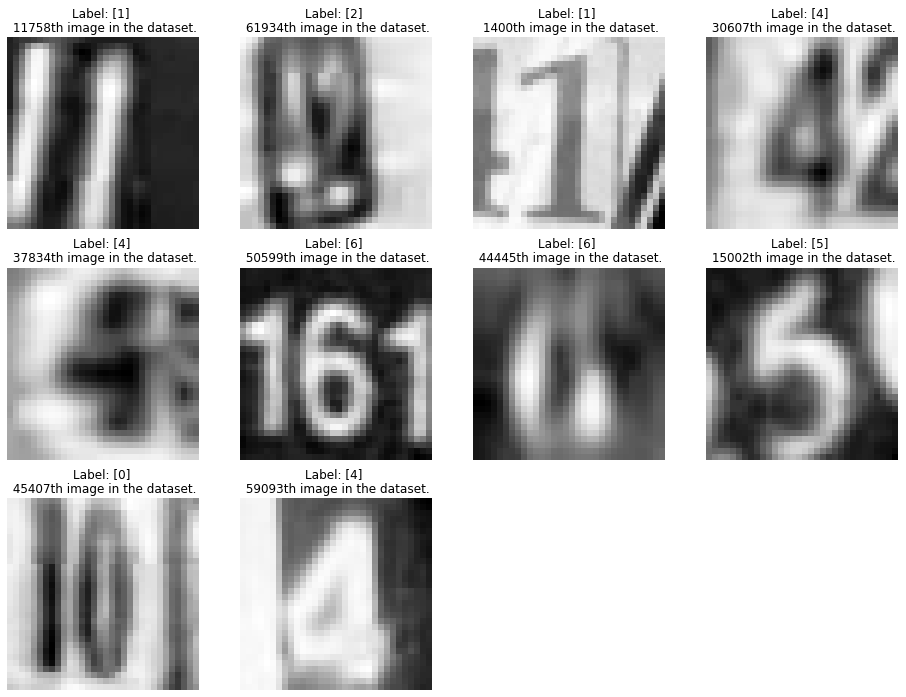

In [16]:
n = 10 # number of images to show
# showing greay images and correspoind labels from train set
show_images(n,train_images_grey,train_labels, cmap='Greys')

## MLP neural network classifier


In [17]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPool2D, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.activations import relu, softmax
from tensorflow.keras import regularizers
from tensorflow.keras.losses import sparse_categorical_crossentropy
from tensorflow.keras.initializers import he_uniform, glorot_normal, zeros, ones
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [53]:

def MLP_NN(input_shape, reg_rate):
    '''
    Multilayer Perceptron (MLP) classification model
    '''
    model = Sequential([
        Flatten(input_shape=input_shape),
        Dense(256, activation='relu', kernel_initializer="he_uniform", bias_initializer="ones",
              kernel_regularizer=regularizers.l2(reg_rate), name='dense_1_relu'),
        Dense(256, activation='relu', kernel_regularizer=regularizers.l2(reg_rate), name='dense_2_relu'),
        Dense(128, activation='relu', kernel_regularizer=regularizers.l2(reg_rate), name='dense_3_relu'),
        Dense(128, activation='relu', kernel_regularizer=regularizers.l2(reg_rate), name='dense_4_relu'),
        Dense(10, activation='softmax', name='dense_5_softmax')
    ])
    return model

In [54]:
def get_checkpoint_best_only(checkpoint_path):
    '''
    save best weights of the model with monitoring validation accuract
    '''
    checkpoint = ModelCheckpoint(checkpoint_path,
                                 save_weights_only=True,
                                 monitor='val_accuracy',
                                 verbose=1,
                                 save_best_only=True)
    
    return checkpoint

In [55]:
def get_test_accuracy(model, x_test, y_test):
    '''
    checking the accuracy of the model on the test sets
    '''
    test_loss, test_acc = model.evaluate(x_test, y_test, verbose=0)
    print(' test accuracy: {acc:0.3f}'.format(acc=test_acc), '\n',
          'test loss: {loss:0.3f}'.format(loss=test_loss))

In [56]:
# creating MLP model for greay scale images
model_MLP = MLP_NN(input_shape=(32,32,1), reg_rate=1e-4)
model_MLP.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_7 (Flatten)          (None, 1024)              0         
_________________________________________________________________
dense_1_relu (Dense)         (None, 256)               262400    
_________________________________________________________________
dense_2_relu (Dense)         (None, 256)               65792     
_________________________________________________________________
dense_3_relu (Dense)         (None, 128)               32896     
_________________________________________________________________
dense_4_relu (Dense)         (None, 128)               16512     
_________________________________________________________________
dense_5_softmax (Dense)      (None, 10)                1290      
Total params: 378,890
Trainable params: 378,890
Non-trainable params: 0
________________________________________________

In [37]:
model_MLP.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

In [38]:
checkpoint_best_only = get_checkpoint_best_only('checkpoints_best_only_MLP\checkpoint')

history_MLP = model_MLP.fit(train_images_grey,
                            train_labels,
                            batch_size=64,
                            epochs=30,
                            validation_split=0.10,
                            callbacks=[EarlyStopping(monitor='val_accuracy', patience=4), checkpoint_best_only]
                           )

Train on 65931 samples, validate on 7326 samples
Epoch 1/30
65344/65931 [============================>.] - ETA: 0s - loss: 1.9994 - accuracy: 0.3075
Epoch 00001: val_accuracy improved from -inf to 0.45482, saving model to checkpoints_best_only_MLP\checkpoint
65931/65931 [==============================] - 10s 152us/sample - loss: 1.9955 - accuracy: 0.3089 - val_loss: 1.5944 - val_accuracy: 0.4548
Epoch 2/30
65600/65931 [============================>.] - ETA: 0s - loss: 1.3879 - accuracy: 0.5511
Epoch 00002: val_accuracy improved from 0.45482 to 0.54846, saving model to checkpoints_best_only_MLP\checkpoint
65931/65931 [==============================] - 8s 124us/sample - loss: 1.3869 - accuracy: 0.5515 - val_loss: 1.4092 - val_accuracy: 0.5485
Epoch 3/30
65920/65931 [============================>.] - ETA: 0s - loss: 1.1795 - accuracy: 0.6334
Epoch 00003: val_accuracy improved from 0.54846 to 0.66284, saving model to checkpoints_best_only_MLP\checkpoint
65931/65931 [=======================

In [39]:
# Functions to plot accuacy and loss
def plot_acc(history):
    try:
        plt.plot(history.history['accuracy'])
        plt.plot(history.history['val_accuracy'])
    except KeyError:
        plt.plot(history.history['acc'])
        plt.plot(history.history['val_acc'])
    plt.title('Accuracy vs. epochs')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Training', 'Validation'], loc='lower right')
    plt.show() 


def plot_loss(history):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Loss vs. epochs')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Training', 'Validation'], loc='upper right')
    plt.show() 

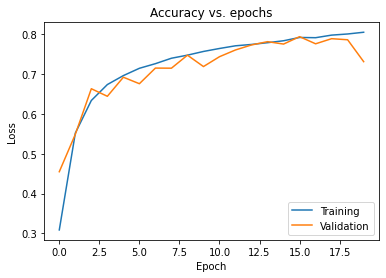

In [40]:
plot_acc(history_MLP)

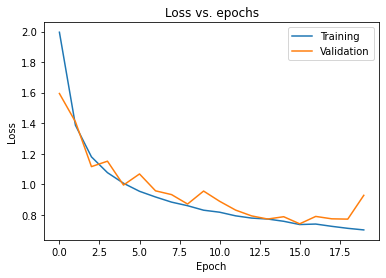

In [41]:
plot_loss(history_MLP)

In [42]:
get_test_accuracy(model_MLP, test_images_grey, test_labels)

 test accuracy: 0.727 
 test loss: 0.977


## CNN neural network classifier

In [51]:

def CNN_NN(input_shape, dropout_rate, reg_rate):
    model = Sequential([
        Conv2D(8, (3,3), activation='relu', input_shape=input_shape, 
               kernel_initializer="he_uniform", bias_initializer="ones", 
               kernel_regularizer=regularizers.l2(reg_rate), name='CONV2D_1_1_relu'),
        BatchNormalization(),
        Conv2D(16, (3,3), activation='relu', kernel_regularizer=regularizers.l2(reg_rate), name='CONV2D_2_2_relu'),
        MaxPool2D((3,3), strides=(2, 2), name='MaxPool2D_1_2_relu'),
        Dropout(dropout_rate),
        BatchNormalization(),
        Conv2D(32, (3,3), activation='relu', kernel_regularizer=regularizers.l2(reg_rate), name='CONV2D_3_3_relu'),
        MaxPool2D((3,3), strides=(2, 2), name='MaxPool2D_2_3_relu'),
        Dropout(dropout_rate),
        BatchNormalization(),
        Flatten(),
        Dense(64, activation='relu', kernel_regularizer=regularizers.l2(reg_rate), name='Dense_1_4_relu'),
        Dense(32, activation='relu', kernel_regularizer=regularizers.l2(reg_rate), name='Dense_2_5_relu'),
        Dense(10, activation='softmax', name='Dense_3_6_softmax')
    ])
    return model

In [52]:
# creating CNN model for greay scale images
model_CNN = CNN_NN(input_shape= (32,32,1), dropout_rate = 0.3, reg_rate=1e-3)
model_CNN.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
CONV2D_1_1_relu (Conv2D)     (None, 30, 30, 8)         80        
_________________________________________________________________
batch_normalization_14 (Batc (None, 30, 30, 8)         32        
_________________________________________________________________
CONV2D_2_2_relu (Conv2D)     (None, 28, 28, 16)        1168      
_________________________________________________________________
MaxPool2D_1_2_relu (MaxPooli (None, 13, 13, 16)        0         
_________________________________________________________________
dropout_10 (Dropout)         (None, 13, 13, 16)        0         
_________________________________________________________________
batch_normalization_15 (Batc (None, 13, 13, 16)        64        
_________________________________________________________________
CONV2D_3_3_relu (Conv2D)     (None, 11, 11, 32)       

In [73]:
model_CNN.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [50]:
checkpoint_best_only = get_checkpoint_best_only('checkpoints_best_only_CNN\checkpoint')

history_CNN = model_CNN.fit(train_images_grey,
                            train_labels,
                            batch_size=32,
                            epochs=30,
                            validation_split=0.10,
                            callbacks=[EarlyStopping(monitor='val_accuracy', patience=4), checkpoint_best_only]
                           )

Train on 65931 samples, validate on 7326 samples
Epoch 1/30
65856/65931 [============================>.] - ETA: 0s - loss: 1.0862 - accuracy: 0.7053
Epoch 00001: val_accuracy improved from -inf to 0.86446, saving model to checkpoints_best_only_CNN\checkpoint
65931/65931 [==============================] - 51s 768us/sample - loss: 1.0856 - accuracy: 0.7054 - val_loss: 0.6397 - val_accuracy: 0.8645
Epoch 2/30
65920/65931 [============================>.] - ETA: 0s - loss: 0.6873 - accuracy: 0.8373
Epoch 00002: val_accuracy improved from 0.86446 to 0.87251, saving model to checkpoints_best_only_CNN\checkpoint
65931/65931 [==============================] - 55s 840us/sample - loss: 0.6873 - accuracy: 0.8373 - val_loss: 0.5876 - val_accuracy: 0.8725
Epoch 3/30
65920/65931 [============================>.] - ETA: 0s - loss: 0.6275 - accuracy: 0.8550
Epoch 00003: val_accuracy did not improve from 0.87251
65931/65931 [==============================] - 55s 840us/sample - loss: 0.6275 - accuracy: 0.

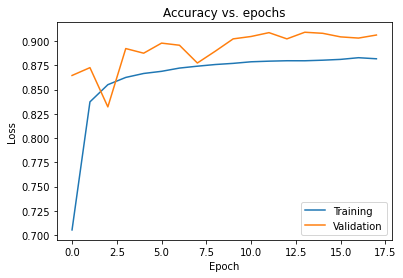

In [71]:
plot_acc(history_CNN)

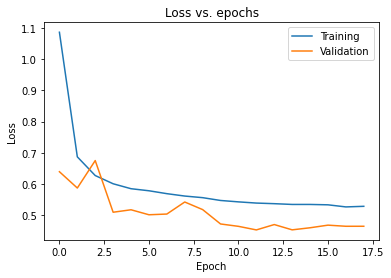

In [72]:
plot_loss(history_CNN)

In [74]:
get_test_accuracy(model_CNN, test_images_grey, test_labels)

 test accuracy: 0.901 
 test loss: 0.356


## Model predictions

In [61]:
def get_model_best_epoch(model, checkpoint_path):
    '''
    get model saved best epoch
    '''
    model.load_weights(checkpoint_path)
    
    return model

In [62]:
# MLP model best epoch
model_MLP = MLP_NN(input_shape=(32,32,1), reg_rate=1e-4)
model_MLP = get_model_best_epoch(model_MLP, 'checkpoints_best_only_MLP\checkpoint')

In [63]:
# CNN model best epoch
model_CNN = CNN_NN(input_shape= (32,32,1), dropout_rate = 0.3, reg_rate=1e-4)
model_CNN = get_model_best_epoch(model_CNN, 'checkpoints_best_only_CNN\checkpoint')

In [64]:
prediction_MLP = model_MLP.predict(test_images_grey)
prediction_MLP_final = np.argmax(prediction_MLP, axis=1) # finding the maximum category
prediction_MLP_final = np.expand_dims(prediction_MLP_final, axis=1) # add the channel dimension
prediction_CNN = model_CNN.predict(test_images_grey)
prediction_CNN_final = np.argmax(prediction_CNN, axis=1) # finding the maximum category
prediction_CNN_final = np.expand_dims(prediction_CNN_final, axis=1) # add the channel dimension

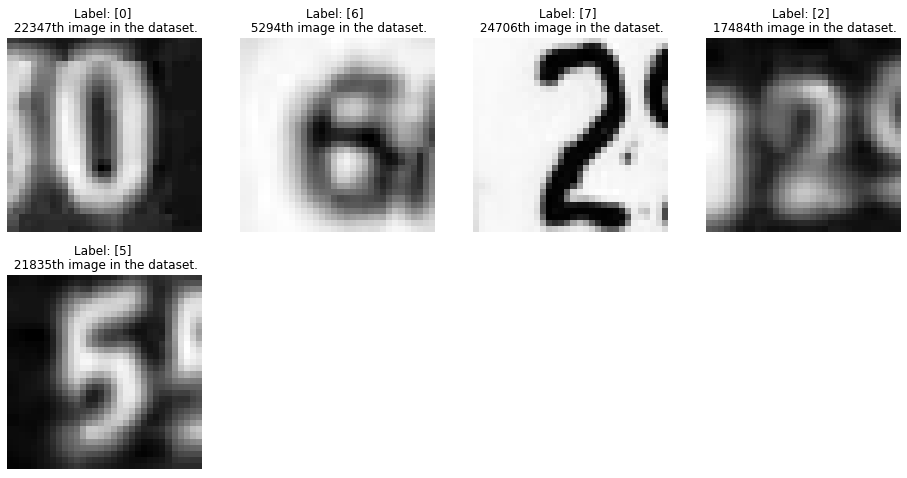

In [65]:
n = 5 # number of images to show
show_images(n,test_images_grey,prediction_MLP_final, cmap='Greys')

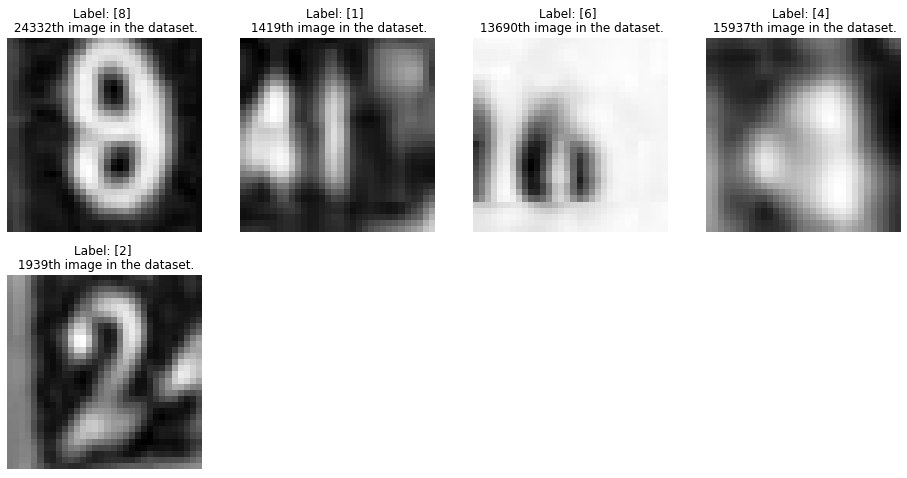

In [66]:
n = 5 # number of images to show
show_images(n,test_images_grey,prediction_CNN_final, cmap='Greys')

In [67]:
def show_images_predictions(n,image_array,label_array1,label_array2, cmap=None):
    '''
    show random n number of images from image_array with corresponding label_array
    the precition of class probablity distibution from each model also would be discplayed
    '''
    random_list = random.sample(range(0, image_array.shape[0]), n)
    fig, axes = plt.subplots(n, 2, figsize=(16, n*6))
    #[axi.set_axis_off() for axi in axes.ravel()] # this line sets all axis off
    category_list1 = list(map(lambda x : x + 0.15, list(range(10)))) 
    category_list2 = list(map(lambda x : x - 0.15, list(range(10)))) 
    r = 0
    for i in random_list:
        image = image_array[i,:,:,:]
        axes[r, 0].set_axis_off()
        axes[r, 0].imshow(np.squeeze(image), cmap=cmap)
        #axes[r, 1].set_title(f"{i}th image in the dataset.")
        axes[r, 1].bar(category_list1,label_array1[i], width=0.3, label='MLP')
        axes[r, 1].bar(category_list2,label_array2[i], width=0.3, label='CNN')
        axes[r, 1].set_title(f"Prediction from MLP model: {np.argmax(label_array1[i,:])} \n Prediction from CNN model: {np.argmax(label_array2[i,:])} ")
        axes[r, 1].legend()
        r += 1
    plt.show()

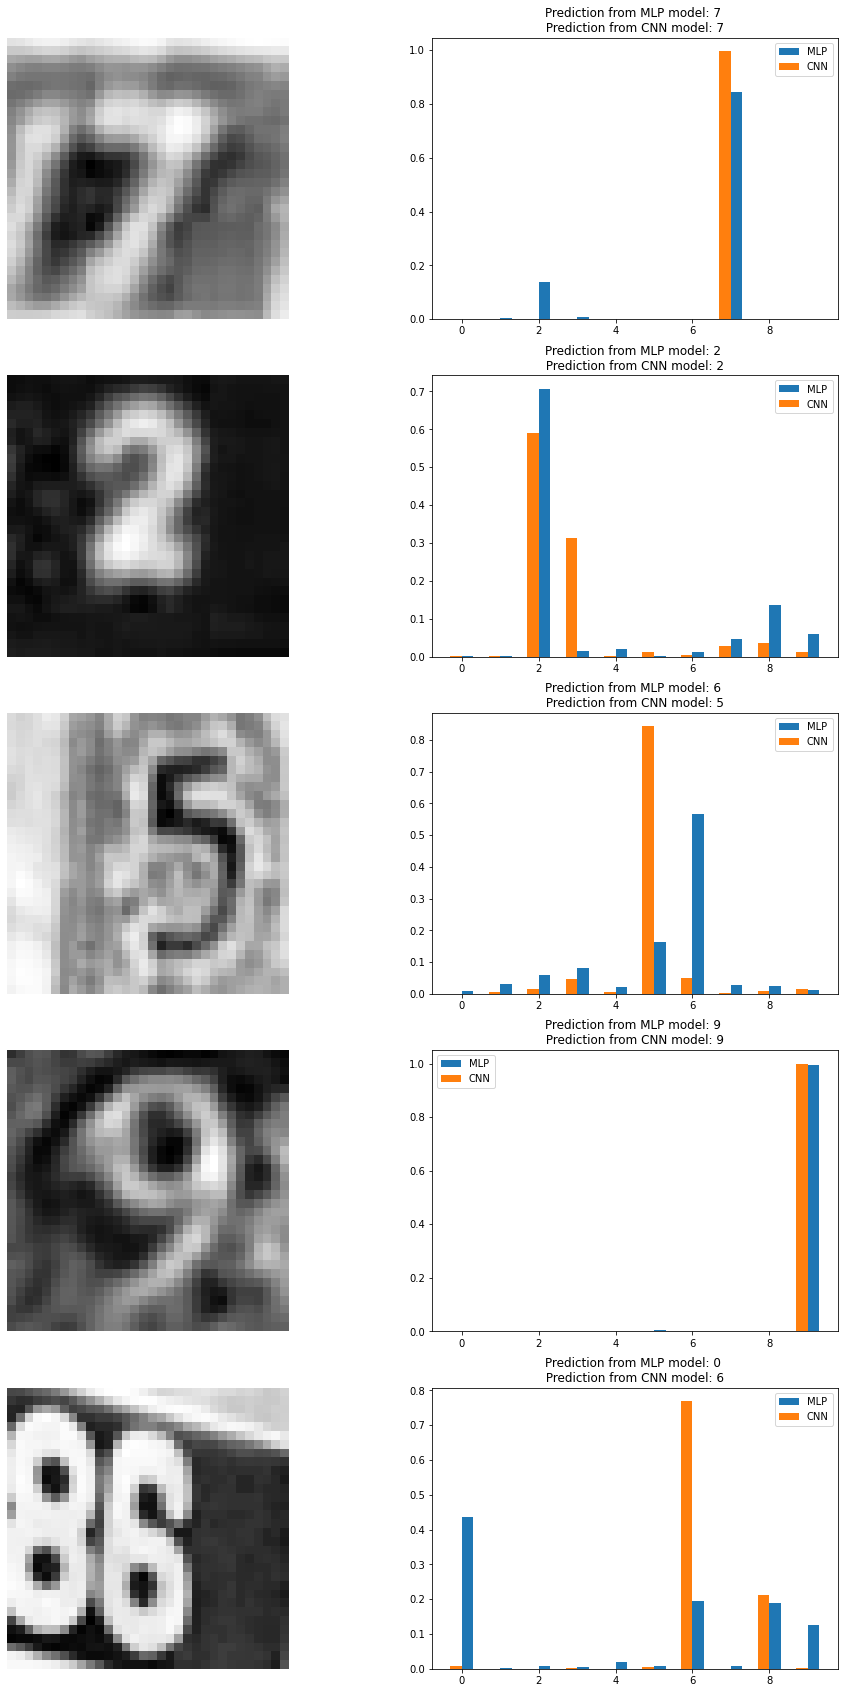

In [68]:
n = 5 # number of random images
show_images_predictions(n,test_images_grey,prediction_MLP, prediction_CNN, cmap='Greys')